In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
#from _future_ import printfunction,unicode literals
import json
import requests
import xlrd
import openpyxl

In [3]:
RANDOM_SEED = 20090425

In [4]:
bj_senti = pd.read_csv("data/Key-Word Beijing Smog PM2.5_senti.csv")

bj_senti

,time,positive,negative
0,2019/3/25,0.198844,0.801156
1,2019/3/24,0.524121,0.475879
2,2019/3/24,0.195922,0.804078
3,2019/3/23,0.193448,0.806552
4,2019/3/22,0.187438,0.812562
...,...,...,...
916,2018/5/11,0.845538,0.154462
917,2017/11/27,0.592485,0.407515
918,2017/10/31,0.863668,0.136332
919,2017/10/16,0.259831,0.740169


In [5]:
bj_senti_mean = bj_senti.mean()
bj_senti_mean

positive    0.534465
negative    0.465535
dtype: float64

In [6]:
bj_senti_var = bj_senti.var()
bj_senti_var

positive    0.086631
negative    0.086631
dtype: float64

In [7]:
bj_senti.positive

0      0.198844
1      0.524121
2      0.195922
3      0.193448
4      0.187438
         ...   
916    0.845538
917    0.592485
918    0.863668
919    0.259831
920    0.747958
Name: positive, Length: 921, dtype: float64

bj_senti = bj_senti.set_index('time')
bj_senti.head(50)

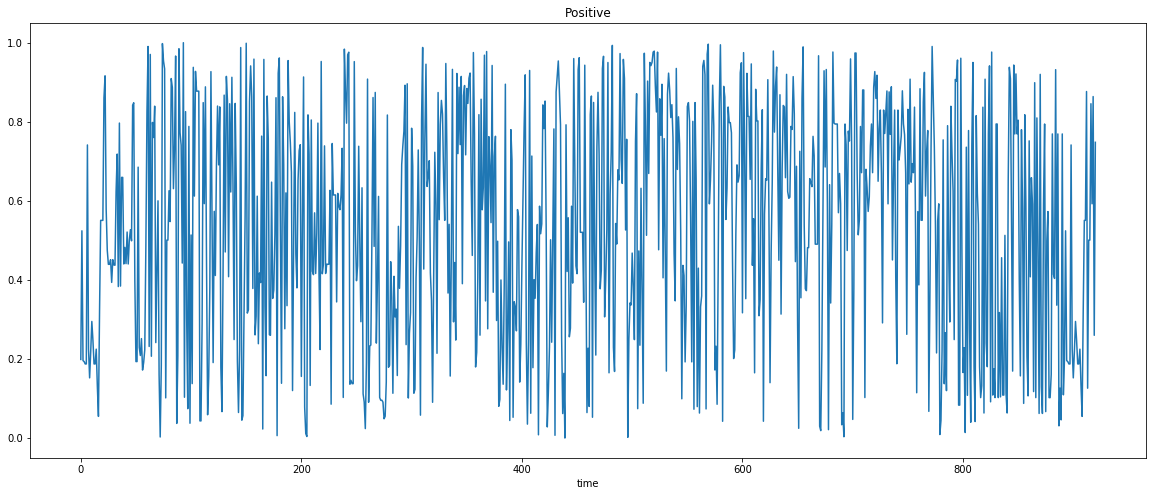

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,8))
plt.plot(bj_senti.positive)
plt.title('Positive')
# plt.ylabel('')
plt.xlabel('time')
plt.grid(False)
plt.show()

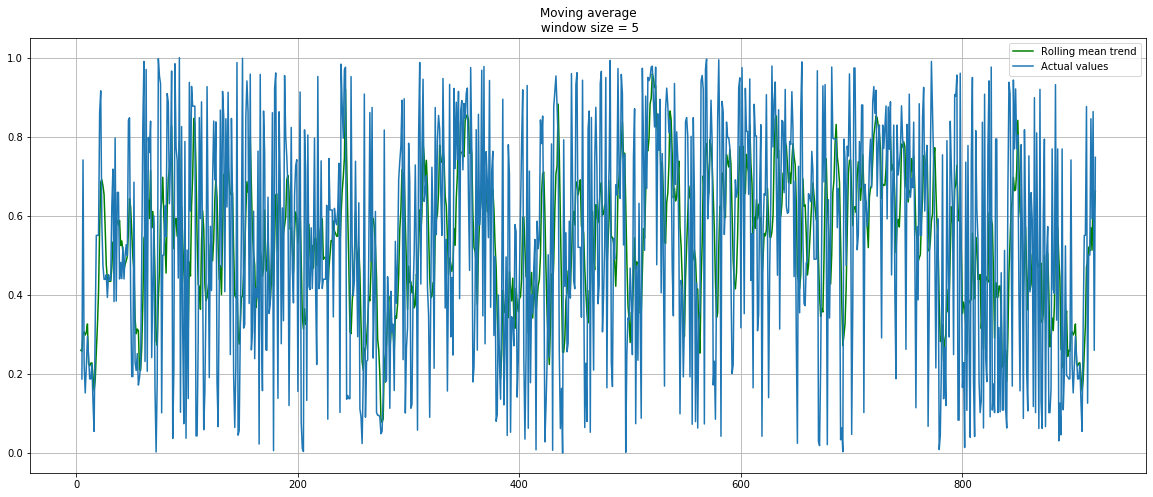

In [9]:
def plot_moving_average(series,window,plot_intervals=False, scale =1.96):
    rolling_mean = series.rolling(window=window).mean()
 
    plt.figure(figsize=(20,8))
    plt.title('Moving average\n window size = {}'.format(window))
    #smaller window, more details; more bigger window, you can see the plot
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    #plt.plot(lwd = 1)

    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')

    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

#Smooth by the previous 5 days (by week)
plot_moving_average(bj_senti.positive, 5)

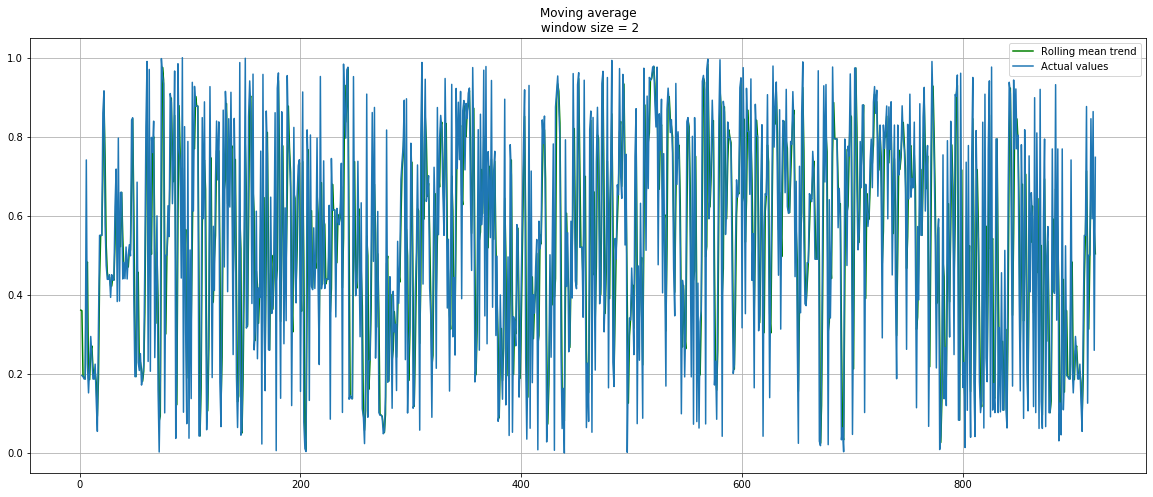

In [10]:
plot_moving_average(bj_senti.positive, 2)

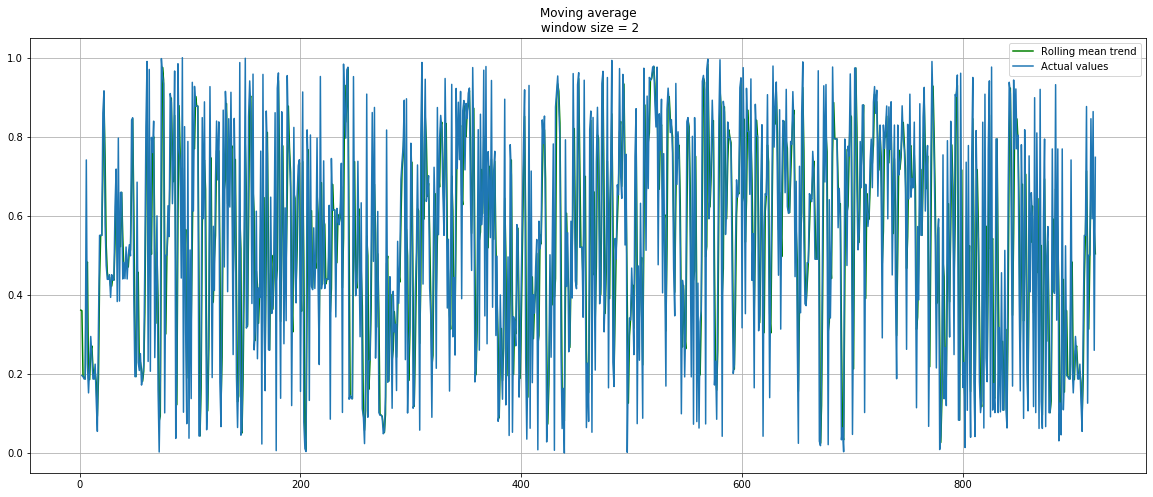

In [11]:
plot_moving_average(bj_senti.positive, 2, plot_intervals=False)

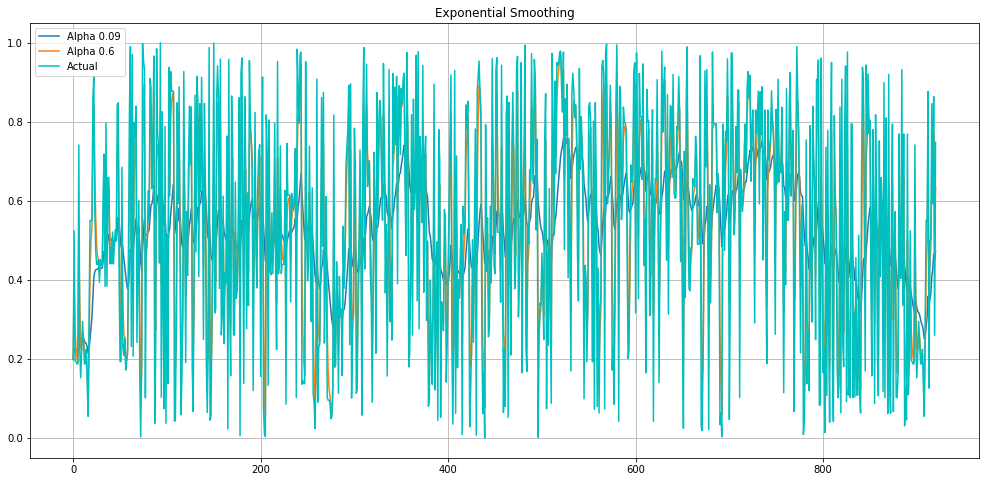

In [12]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def plot_exponential_smoothing(series, alphas):
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);
        
plot_exponential_smoothing(bj_senti.positive, [0.09, 0.6])

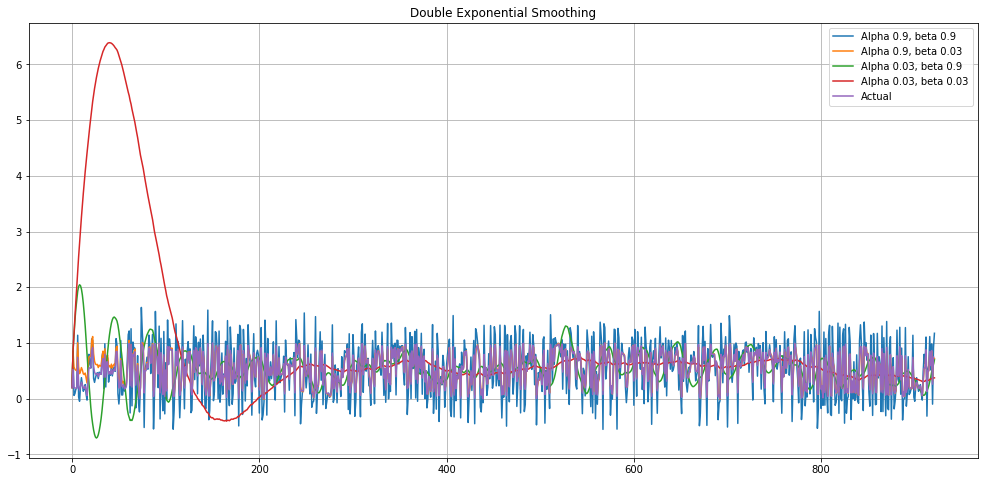

In [13]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

plot_double_exponential_smoothing(bj_senti.positive, alphas=[0.9, 0.03], betas=[0.9, 0.03])

In [14]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [15]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Positive Value')
    plt.plot(predicted, color='blue',label='Predicted Positive Value')
    plt.title('Positive Value Prediction')
    plt.xlabel('Time')
    plt.ylabel('Positive Value')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))


In [16]:
# First, we get the data
dataset = pd.read_csv('data/Key-Word Beijing Smog PM2.5_senti.csv', index_col='time', parse_dates=['time'])
dataset = dataset.sort_values(by="time" , ascending=True)
dataset

,positive,negative
time,,
2017-01-06,0.591125,0.408875
2017-01-06,0.117561,0.882439
2017-01-06,0.898770,0.101230
2017-01-06,0.102248,0.897752
2017-01-06,0.809651,0.190349
...,...,...
2019-03-24,0.524121,0.475879
2019-03-24,0.524121,0.475879
2019-03-24,0.195922,0.804078


In [17]:
dataset["newindex"] = range(len(dataset))
dataset

,positive,negative,newindex
time,,,
2017-01-06,0.591125,0.408875,0
2017-01-06,0.117561,0.882439,1
2017-01-06,0.898770,0.101230,2
2017-01-06,0.102248,0.897752,3
2017-01-06,0.809651,0.190349,4
...,...,...,...
2019-03-24,0.524121,0.475879,916
2019-03-24,0.524121,0.475879,917
2019-03-24,0.195922,0.804078,918


In [18]:
dataset = dataset.set_index('newindex')
dataset

,positive,negative
newindex,,
0,0.591125,0.408875
1,0.117561,0.882439
2,0.898770,0.101230
3,0.102248,0.897752
4,0.809651,0.190349
...,...,...
916,0.524121,0.475879
917,0.524121,0.475879
918,0.195922,0.804078


In [20]:
# Checking for missing values
training_set = dataset[:720].iloc[:,:-1].values
test_set = dataset[720:].iloc[:,:-1].values
training_set.shape

(720, 1)

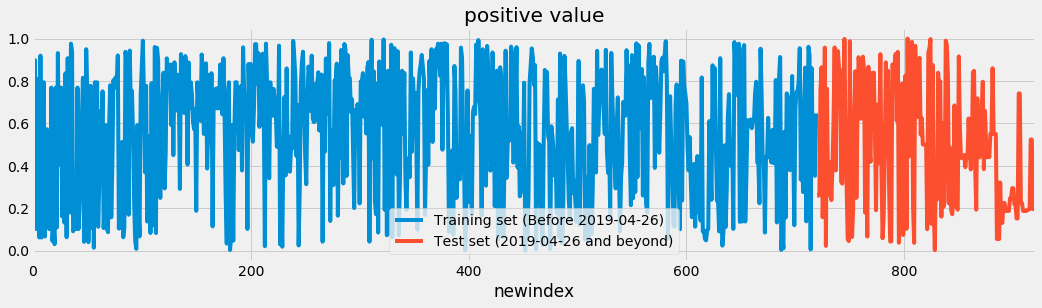

In [21]:
dataset["positive"][:720].plot(figsize=(16,4),legend=True)
dataset["positive"][720:].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2019-04-26)','Test set (2019-04-26 and beyond)'])
plt.title('positive value')
plt.show()

In [22]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(30,720):
    X_train.append(training_set[i-30:i,0])
    y_train.append(training_set[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [23]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [24]:
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
690/690 [==============================] - 2s 3ms/step - loss: 0.1353
Epoch 2/50
690/690 [==============================] - 1s 1ms/step - loss: 0.0917
Epoch 3/50
690/690 [==============================] - 1s 1ms/step - loss: 0.0947
Epoch 4/50
690/690 [==============================] - 1s 1ms/step - loss: 0.0914
Epoch 5/50
690/690 [==============================] - 1s 1ms/step - loss: 0.0957
Epoch 6/50
690/690 [==============================] - 1s 1ms/step - loss: 0.0876
Epoch 7/50
690/690 [==============================] - 1s 1ms/step - loss: 0.0873
Epoch 8/50
690/690 [==============================] - 1s 1ms/step - loss: 0.0902
Epoch 9/50
690/690 [==============================] - 1s 1ms/step - loss: 0.0910
Epoch 10/50
690/690 [==============================] - 1s 1ms/step - loss: 0.0882
Epoch 11/50
690/690 [==============================] - 1s 1ms/step - loss: 0.0856
Epoch 12/50
690/690 [==============================] - 1s 1ms/step - loss: 0.0871
Epoch 13/50
690/690 [====

In [25]:
sc = MinMaxScaler(feature_range=(0,1))
training_set = sc.fit_transform(training_set)
training_set

array([[0.59334854],
       [0.1179732 ],
       [0.90217038],
       [0.10260208],
       [0.8127109 ],
       [0.47901712],
       [0.06241494],
       [0.92328874],
       [0.06241494],
       [0.59455919],
       [0.79724722],
       [0.06704474],
       [0.50072223],
       [0.57499783],
       [0.1307669 ],
       [0.10260208],
       [0.10260208],
       [0.77205343],
       [0.04614016],
       [0.12668357],
       [0.03089695],
       [0.77205343],
       [0.10971105],
       [0.93524148],
       [0.40529178],
       [0.41557685],
       [0.77205343],
       [0.16188539],
       [0.33729997],
       [0.13264347],
       [0.83993491],
       [0.06354425],
       [0.91105087],
       [0.24091747],
       [0.18105786],
       [0.97990336],
       [0.94484428],
       [0.09194196],
       [0.10908721],
       [0.17549057],
       [0.10260208],
       [0.77205343],
       [0.10260208],
       [0.22915356],
       [0.54294974],
       [0.62076424],
       [0.81858448],
       [0.041

In [26]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = pd.concat((dataset["positive"][:720],dataset["positive"][720:]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 30:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)
inputs

array([[0.56327047],
       [0.15639002],
       [0.7446622 ],
       [0.7295176 ],
       [0.65476481],
       [0.38115077],
       [0.46711296],
       [0.8266884 ],
       [0.49377312],
       [0.12049522],
       [0.67487362],
       [0.75078178],
       [0.75078178],
       [0.80339144],
       [0.95828694],
       [0.33600467],
       [0.62241862],
       [0.2774182 ],
       [0.69338414],
       [0.86636009],
       [0.13897103],
       [0.52871754],
       [0.96500323],
       [0.92601177],
       [0.00607856],
       [0.86401254],
       [0.37593078],
       [0.51704952],
       [0.35438927],
       [0.64966865],
       [0.26078769],
       [0.26078769],
       [0.26241221],
       [0.75996406],
       [0.86830659],
       [0.15825899],
       [0.3356247 ],
       [0.96128109],
       [0.02286149],
       [0.76653312],
       [0.26178981],
       [0.30941508],
       [0.4191223 ],
       [0.23941615],
       [0.394671  ],
       [0.61400348],
       [0.9620184 ],
       [0.379

In [27]:
inputs[1:1,0]

array([], dtype=float64)

In [28]:
test_set.shape

(201, 1)

In [31]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(30,231):
    X_test.append(inputs[i-30:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_positive_value = regressor.predict(X_test)
predicted_positive_value = sc.inverse_transform(predicted_positive_value)

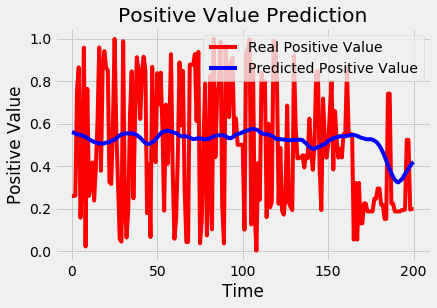

In [32]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_positive_value)

In [31]:
# Evaluating our model
return_rmse(test_set,predicted_positive_value)

The root mean squared error is 0.3684643685493728.
